# Indegenous Cattle Breed Classifier Model

### Problem Statement:
In our country we have a ton of different cattle breeds. Each breed is unique and they transmit different characterstics in term of milk quality etc.
Their price vary based on their breed. It is very hard for a farmer to correctly identify the correct breed since some breeds seem similar in color and body structure.

### Propeosed solution
We want to build an AI based App which will process the image and come up with correct breed name. With this app they will get a range of prediction with assigned probability.

### Methodology
* Collect the relevant data
* Preprocess the images
* Remove the noisy images and wrongly labled ones
* EDA
* Transfer learning
* Model training
* Fine tuning
* Testing
* Deployment

### Technology Stacks
- Python
- Pytorch
- Numpy
- Matplotlib
- Scikit Learn


### Contents

1. Installation and Imports
2. Drive mounting
3. Data Loading
4. Basic preprocessing
5. Exploratory Data Analysis
6. Image Transformation
7. Test/Train Data split
8. Vanilla Model (CNN based) Building
9. Data Augmentation
10. Vanilla model over transformed images
11. Transfer Learning
12. Fine tuning
13. Hyper parameter tuning
14. Output Evaluations and Model selection
15. Deployment


#### Installation and Imports

In [ ]:
#install pytorch
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import stuffs
import numpy as np # for numpy arrays
import matplotlib.pyplot as plt #for plotting the tensor
#pytorh modules
import torch
import torchvision
from torchvision.transforms import ToTensor

#### Mount Google Drive

I have uploaded the data on my google drive. I need to mount it here. And then I need to authorized using my drive credentials to fetch the data directly from drive.


In [ ]:
#import drive module from google.colab
from google.colab import drive
#define the folder of drive you want to mount
drive_folder_path = '/content/drive'
#mount it
drive.mount(drive_folder_path)

Mounted at /content/drive


I have uploaded the image data as a zip file(`Cattle-20230102T064745Z-001.zip`) on my google drive. Need to unzip it and load it using `torchvision` library in `pytorch`.

In [ ]:
import os
#unzip the images
# -d is for destination folder of final unzipped files
destination_folder = "/content/drive/MyDrive/cattle_images"
#check if it already there or not
if(os.path.exists(destination_folder)):
  print("Folder is already there!")
else:
  print(f"Unzipping the zipped file to {destination_folder}")
  !unzip "/content/drive/MyDrive/Cattle-20230102T064745Z-001.zip" -d "/content/drive/MyDrive/cattle_images"

Folder is already there!


#### Basic Preprocessing
All files inside `data_path` meant to be of image data type like `jpg, png` etc. Let's check the validity of each image using Python Image Library `PIL`.

In [ ]:

from PIL import Image

'''

function for validating images and removing the unsupported files inplace
input : image directory path
ouput : None
objective : check and validate the data type of each file in root_folder and delete/remove them if format is not supported/valid.

'''

def validate_and_remove_images(root_folder):

  print("root_folder : ",root_folder)

  for dirpath, dirnames, filenames in os.walk(root_folder):

      print("dirpath : ",dirpath)
      for filename in filenames:

          file_path = os.path.join(dirpath, filename)
          print("file_path : ",file_path)
          print(file_path)
          try:
              img = Image.open(file_path)
              # this will throw an exception if the file is not supported or corrupted
              img.verify()
          except (IOError, SyntaxError) as e:
              print(f"Removing unsupported image file: {file_path}")
              os.remove(file_path)

In [ ]:
#validate the files using function validate_and_remove_images
#define root folder
%%time
root_folder = "/content/drive/MyDrive/cattle_images"
#validate_and_remove_images(root_folder)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


#### Load the Data

Now, we have removed the unsupported files from our image data. We can load the data and do some EDA over it.


In [ ]:
%%time
#since images are stored in a folder we need ImageFolder class to load them
from torchvision.datasets import ImageFolder
# Define the path to the folder containing the unzipped images
data_path = '/content/drive/MyDrive/cattle_images/Cattle'
# Load the images from the folder using the ImageFolder dataset
cattle_dataset = ImageFolder(root=data_path)
print(f"cattle_dataset data type : {type(cattle_dataset)}")

cattle_dataset data type : <class 'torchvision.datasets.folder.ImageFolder'>
CPU times: user 42 ms, sys: 9.02 ms, total: 51 ms
Wall time: 4.83 s


`cattle_dataset` contains all the images that are present at `data_path`.
Since data has been loaded into `cattle_dataset` variable, let's perform some basic Exploratory Data Analysis over it.

#### Basic EDA

##### Display some sample data

`cattle_dataset` is of type `torchvision.datasets.folder.ImageFolder`.

It can be imagined like collection of tuple having 1st element as image of type `PIL.Image.Image` and 2nd element as the label of that image of type `int`.

`cattle_dataset = [(image1,label1),(image2,label2),....,(imagen,labeln)]`


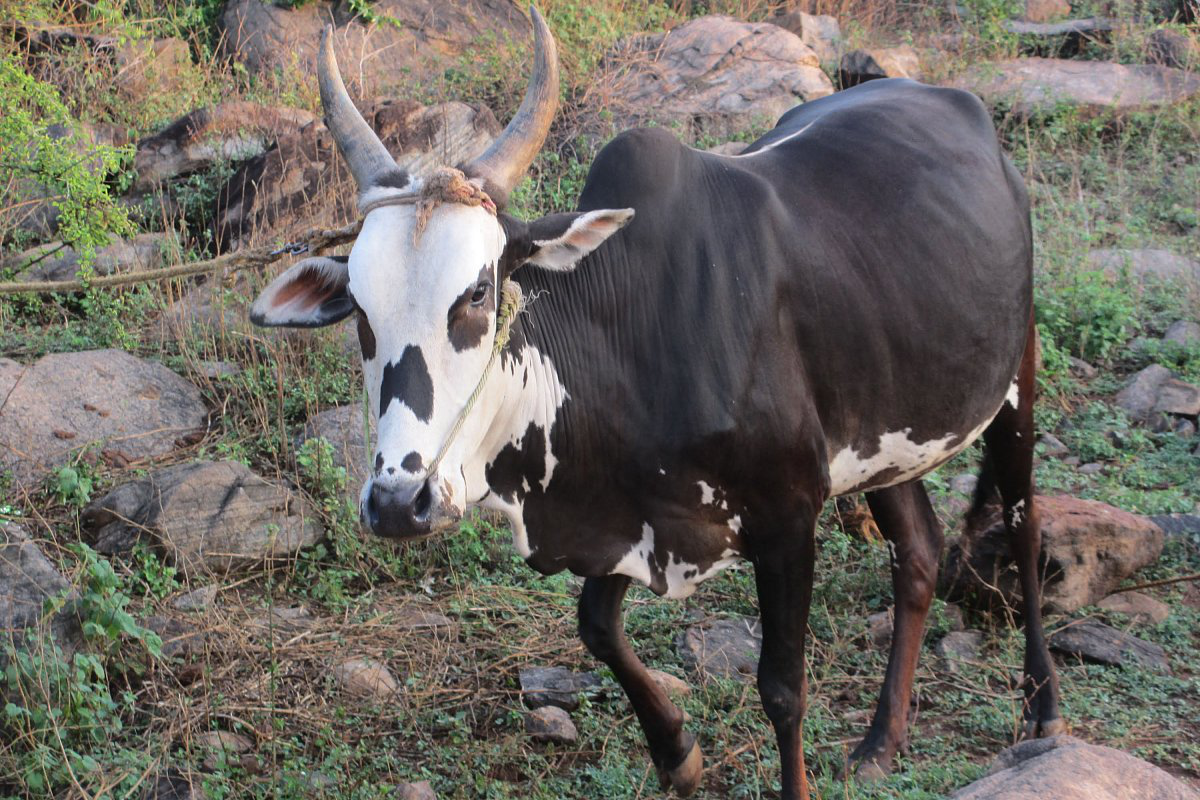

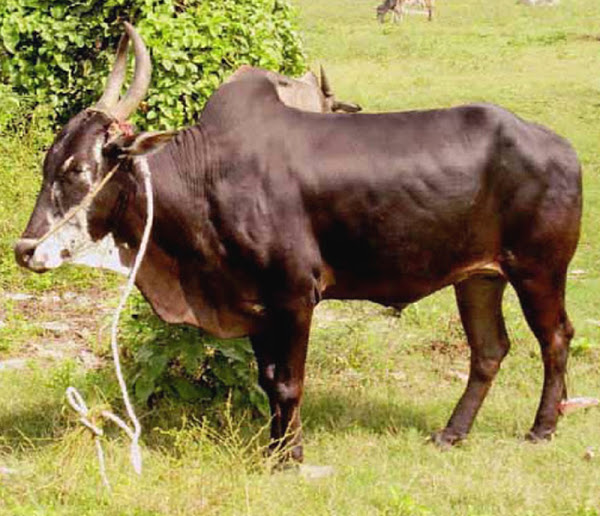

In [ ]:
#display some sample images
from IPython.display import display
display(cattle_dataset[0][0])
display(cattle_dataset[1][0])

* *Quick Observation :* Image size and quality seems not uniformly distributed.

##### Descriptive properties of Data

1. Data count, size and shape
2. Label counts and actual values
3. Count of Images for each category
4. Maximum and minimum count across all the categories
5. Image shape and size

In [ ]:
#data count
print(f"Total image counts : {len(cattle_dataset)}")
#total distinct labels
print(f"Total distinct labels : {len(cattle_dataset.classes)}")
#actual values
print(f"Categories Name : {', '.join(cattle_dataset.classes)}")
#encoded label
#pytorch has encoded the actual categories name into discrete values starting from 0 to total categories - 1
print(f"Encoded labels for each category : {', '.join(list(map(lambda x:str(cattle_dataset.class_to_idx[x]),cattle_dataset.classes)))}")



Total image counts : 3047
Total distinct labels : 26
Categories Name : Alambadi Cow, Amritmahal Cow, Banni Buffalo, Bargur Cow, Dangi Cow, Deoni Cow, Gir Cow, Hallikar Cow, Jaffrabadi Buffalo, Kangayam Cow, Kankrej Cow, Kasaragod Cow, Kenkatha Cow, Kherigarh Cow, Malnad gidda Cow, Mehsana Buffalo, Nagori Cow, Nagpuri Buffalo, Nili ravi Buffalo, Nimari Cow, Pulikulam Cow, Rathi Cow, Sahiwal Cow, Shurti Buffalo, Tharparkar Cow, Umblachery Cow
Encoded labels for each category : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25


In [ ]:
#create a dict having key as a labels and value as a actual values of that label
label_to_values = dict(zip(list(map(lambda x:(cattle_dataset.class_to_idx[x]),cattle_dataset.classes)),(cattle_dataset.classes)))
labels = label_to_values.keys()
values = label_to_values.keys()
#count or instances of each label in dataset
from collections import Counter # counter will transform list into a dict having values in list as a key and their count in list as values
label_counts = Counter(list(map(lambda x : x[1],cattle_dataset)))
print("Label : Count")
for label,count in label_counts.items():
  print(f"{label} : {count}")

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Label : Count
0 : 93
1 : 95
2 : 36
3 : 60
4 : 84
5 : 102
6 : 249
7 : 185
8 : 102
9 : 116
10 : 177
11 : 95
12 : 56
13 : 36
14 : 107
15 : 96
16 : 89
17 : 217
18 : 92
19 : 87
20 : 126
21 : 148
22 : 239
23 : 60
24 : 221
25 : 79


#### Advanced EDA

In above section, I did initial review over our image dataset like how many labels it has, the distrbution of count over each label, maximum count and minimum count of instances etc.

In this section, I will explore somewhat elegant way to look at same stats about data, different types of Image transformations techniques and Image augmentations techniques. At last I will also explore mapping the data to lower dimensional space i.e dimensionality reductions algorithm for image compression.

It will cover:

1. Graphical representation of instance count distrbution
2. Image transformation techniques
  - Pixel visualisations
  - Resizing
  - Image rotation and flipping
  - cropping
  - Image normalization

3. Pixel Intensities visualisations
4. Heatmaps for Region of Interest (ROI)
5. Dimension Reductions
6. Image Augmentation


<AxesSubplot:>

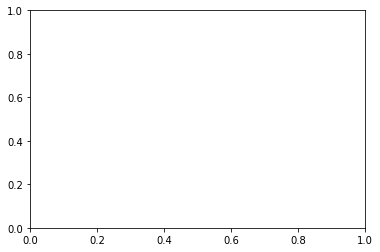

In [ ]:
plt.subplot()

In [ ]:
#function for getting a frame of specified shape
'''
input - no of rows, columns and fig size of a frame
output - the resultant frame

'''
def get_image_frame(nrows=1,ncols=1,figsize=(36,24)):
    #create subplots
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    if(ncols==1):
      return [axs]
    return axs



In [ ]:
#function for plotting graphs
'''
input : x values, y values, xlabel name, ylabel name and graph name
output : bar plot for x, y values using matplotlib.pyplot module

'''
def plot_graph(axs,x,y,xlabels,ylabels,title='My Graph',rotation=45,width=.5):

  if(len(x)!=len(y)):
    print("Input variables are not appropriate")
  else:
    #get image
    for i in range(len(axs)):
      axs[i].bar(x[i],y[i],width=width,edgecolor='white',align='edge')
      axs[i].set_title(title)
      axs[i].set_xlabel(xlabels[i])
      axs[i].set_ylabel(ylabels[i])
      # Rotate the x-axis labels by 45 degrees
      #axs[i].set_xticks(x[i])
      # add some spacing between each bar
      axs[i].set_xticks([i + width/2 for i in range(len(x[i]))])
      axs[i].set_xticklabels(x[i])
      axs[i].tick_params(axis='x',labelrotation=rotation)
    #provide some subspace between them
    plt.subplots_adjust(wspace=0.5)
    plt.show()



In [ ]:
#plot the labels on x axis and counts on y-axis
encoded_labels = list(label_counts.keys())
counts = list(label_counts.values())
#replace labels with actual values
encoded_labels_to_actual_labels = dict(map(lambda x:(str(cattle_dataset.class_to_idx[x]),x),cattle_dataset.classes))
#sort the actual_label_counts by value
actual_label_counts = dict(map(lambda x:(encoded_labels_to_actual_labels[str(x[0])],x[1]),label_counts.items()))
actual_label_counts = dict(sorted(actual_label_counts.items(),key = lambda x:x[1]))
#plot both graph side by side
#get a frame with size 1by2
axs = get_image_frame(1,2)
#define x and y values
x = [encoded_labels,list(actual_label_counts.keys())]
y = [counts,list(actual_label_counts.values())]
xlabels = ['encoded_labels','actual_labels']
ylabels = ['encoded_labels_count','actual_labels_count']
plot_graph(axs,x,y,xlabels,ylabels)

NameError: ignored

*Quick Observations: Banni Buffalo has least number of images in the our dataset and Gir Cow has maximum image instances*

#### Image Transformation

1. Image to pixel transformations
2. Image Resizing


##### Image to Pixel transformation

*Pixels* - pixels (short for "picture elements") are the smallest individual units of an image. Each pixel represents a single point in the image, and its value determines the color and brightness of that point.

In `pytorch` we have `transforms` in `torchvision` module which we can use for transforming images to tensors.

In [ ]:
#image to pixel transformation
import torchvision.transforms as transforms
image_to_pixel_transform = transforms.ToTensor()
#load the images from data path and apply tensor transform over them
cattle_dataset_in_pixels = ImageFolder(root=data_path,transform=image_to_pixel_transform)
#display tensor
print(cattle_dataset_in_pixels[0])


(tensor([[[0.5804, 0.6314, 0.6667,  ..., 0.6824, 0.6863, 0.6902],
         [0.5765, 0.5882, 0.6392,  ..., 0.6235, 0.6627, 0.7059],
         [0.4784, 0.5020, 0.6157,  ..., 0.5137, 0.5765, 0.6980],
         ...,
         [0.2667, 0.2784, 0.2235,  ..., 0.7922, 0.7529, 0.6980],
         [0.2980, 0.3373, 0.3333,  ..., 0.7922, 0.7686, 0.7137],
         [0.2980, 0.3137, 0.2980,  ..., 0.7843, 0.7882, 0.7647]],

        [[0.4078, 0.4706, 0.5333,  ..., 0.7176, 0.6549, 0.6157],
         [0.4118, 0.4353, 0.5098,  ..., 0.6510, 0.6314, 0.6392],
         [0.3333, 0.3608, 0.4902,  ..., 0.5333, 0.5529, 0.6431],
         ...,
         [0.3255, 0.3294, 0.2745,  ..., 0.6941, 0.6549, 0.6000],
         [0.3647, 0.4039, 0.4000,  ..., 0.6941, 0.6745, 0.6196],
         [0.3725, 0.3882, 0.3725,  ..., 0.6902, 0.6941, 0.6706]],

        [[0.3098, 0.3451, 0.3569,  ..., 0.7373, 0.7137, 0.6941],
         [0.3255, 0.3137, 0.3412,  ..., 0.6745, 0.6824, 0.7098],
         [0.2627, 0.2588, 0.3412,  ..., 0.5490, 0.5922, 0

Now we have transformed raw images to their pixels values. We can visualize these tensors with help of `matplotlib` library.
Let's write a function for displaying images from tensor to raw image.

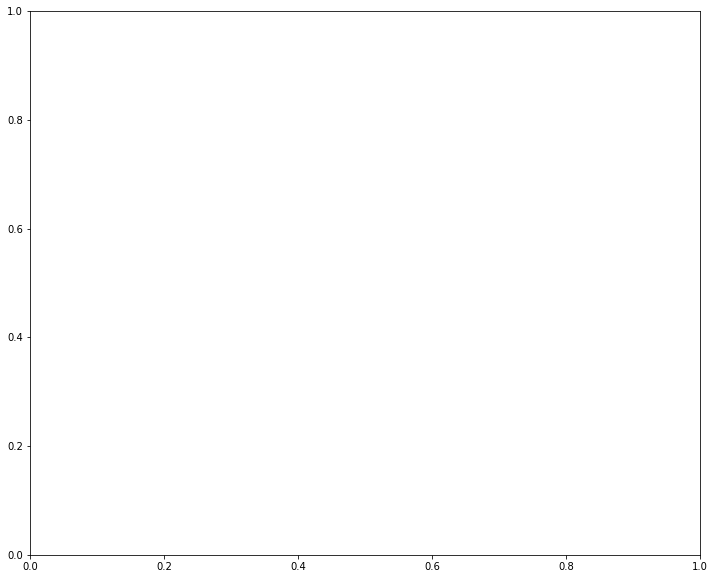

In [ ]:
axs = get_image_frame(1,1,(12,10))

In [ ]:
#function for transforming images to pixels
'''
input - tensors and corresponding label
output - image

'''

def display_images_from_tensor(tensors,labels):
  # Get the images corresponding to the selected indices
  num_images = len(tensors)
  print(f"num_images : {num_images}")
  #get a image frame of shape (1)by(num_images)
  axs = get_image_frame(1,num_images,(12,10))
  for i in range(num_images):
      # Convert the tensor to a numpy array and display the image
      axs[i].imshow(tensors[i].permute(1, 2, 0))
      axs[i].set_title(f"Label: {labels[i]}")
      axs[i].axis('off')
  plt.show()

In [ ]:
display_images_from_tensor([cattle_dataset_in_pixels[0][0],cattle_dataset_in_pixels[1][0]],["Gir","Gir"])

In [ ]:
x = [[1,2],[2,3],[3,4]]
x[:2]

[[1, 2], [2, 3]]

In [ ]:
selected_tensor = [t for t,i in cattle_dataset_in_pixels if i==24]

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
len(selected_tensor[:2])

2

actual_label : Alambadi Cow
encoded_label : 0


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


selected_tensor length :  93
num_images : 2


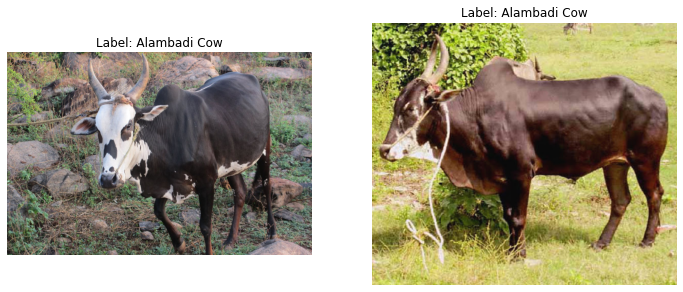

actual_label : Amritmahal Cow
encoded_label : 1
selected_tensor length :  95
num_images : 2


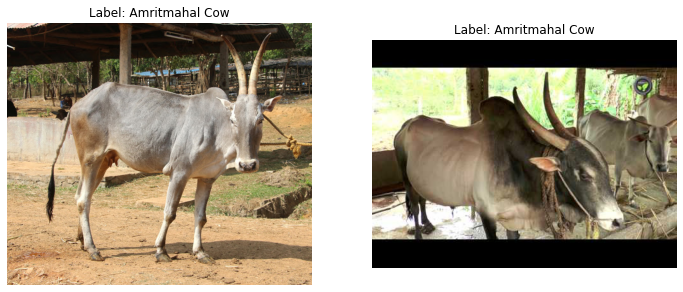

In [ ]:
#disply 2 images from each category
num_of_iteration = 2
for encoded_label,actual_label in encoded_labels_to_actual_labels.items():
  print(f"actual_label : {actual_label}")
  print(f"encoded_label : {encoded_label}")
  selected_tensor = [t for t,i in cattle_dataset_in_pixels if i==int(encoded_label)]
  print("selected_tensor length : ",len(selected_tensor))
  display_images_from_tensor(selected_tensor[:2],[actual_label]*len(selected_tensor))
  num_of_iteration = num_of_iteration-1
  if num_of_iteration==0:
    break

Now we are able to convert image to their pixel representation and vice versa.
If you look at the sample images that I ahve displayed here, you obeserve that the shape of images are not similar even in each category.
This is where `resizing` comes into picture.


#### Resizing

Transformation of images to certain shape is called resizing.
For our usecase resizing is important because at the end of the day we will be training a deep learning model using these images. In deep learning models, we will have fixed number of input neurans. If the shape varies, then we need to vary the number of input neurans which is not possible.

Resizing images come at its own cost. Resizing might cause loss of some information so it is important to decide the right size for the images that balance the trade-off between information loss and model performance.

In pytorch, the `torchvision.transforms.Resize` class can be used to resize images.

In [ ]:
#resize the input image to 224by224
import torchvision.transforms as transforms
pixel_tensor = ToTensor()
resize_transform = transforms.Resize((224,224))
#apply transformation
transformations_chain = transforms.Compose([
    pixel_tensor,
    resize_transform,
])
cattle_image_tranformed = ImageFolder(data_path,transform=transformations_chain)


In above step, we have applied a chain of transformation over out input image dataset. Firstly we are transforming image into pixel transformation then we are resizing them into `224x224`.
In resizing we are expecting degradation in quality. Let's confirm this by diaplying some sample from `cattle_image_tranformed`

actual_label : Alambadi Cow
encoded_label : 0
selected_tensor length :  93
num_images : 2


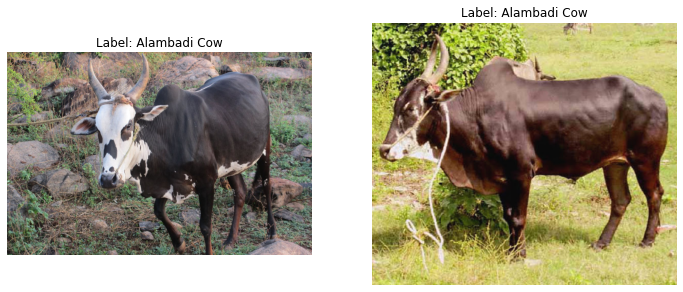

actual_label : Amritmahal Cow
encoded_label : 1
selected_tensor length :  95
num_images : 2


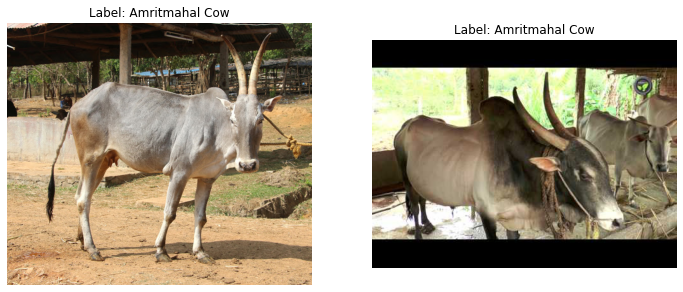

In [ ]:
#disply 2 images from each category
num_of_iteration = 2
for encoded_label,actual_label in encoded_labels_to_actual_labels.items():
  print(f"actual_label : {actual_label}")
  print(f"encoded_label : {encoded_label}")
  selected_tensor = [t for t,i in cattle_dataset_in_pixels if i==int(encoded_label)]
  print("selected_tensor length : ",len(selected_tensor))
  display_images_from_tensor(selected_tensor[:2],[actual_label]*len(selected_tensor))
  num_of_iteration = num_of_iteration-1
  if num_of_iteration==0:
    break

*Quick Observation : Images seem have similar size and Quality seems a bit reduced wrt previous one*


##### Image Rotations and Flipping

I have demonstrated two of the most popular image transformations techniques.
Image rotations and flippings is also one of the many techniques.

We might need to apply this transformation techniques if our usecase need data augmenations, or mirror symmetry.

In pytorch, we can perform image `rotations` and `flipping` using the `transforms` module. The `transforms` module provides various functions to transform and augment images.
Here are some commonly used transformations:
1. `RandomRotation` : RandomRotation: This transformation rotates the image by a random angle within a given range.
2. `RandomHorizontalFlip` : This transformation flips the image horizontally with a probability of 0.5.
3. `RandomVerticalFlip` : This transformation flips the image vertically with a probability of 0.5.




In [ ]:
#rotate and flip the images
import torchvision.transforms as transforms
random_rotation = transforms.RandomRotation(0.5)
transformations_chain = transforms.Compose([
    random_rotation,
    pixel_tensor,
    resize_transform
])
#apply above transformations
cattle_image_rotated = ImageFolder(root=data_path,transform=transformations_chain)

actual_label : Alambadi Cow
encoded_label : 0
selected_tensor length :  93
num_images : 2


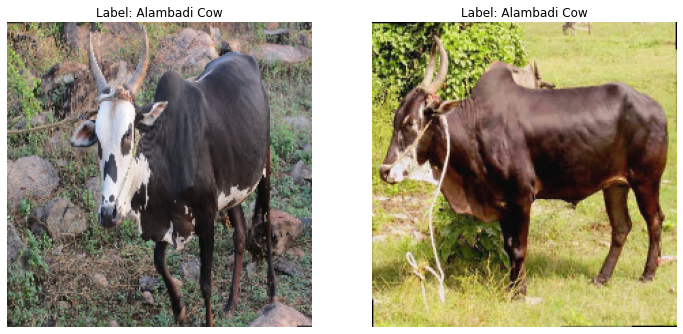

actual_label : Amritmahal Cow
encoded_label : 1
selected_tensor length :  95
num_images : 2


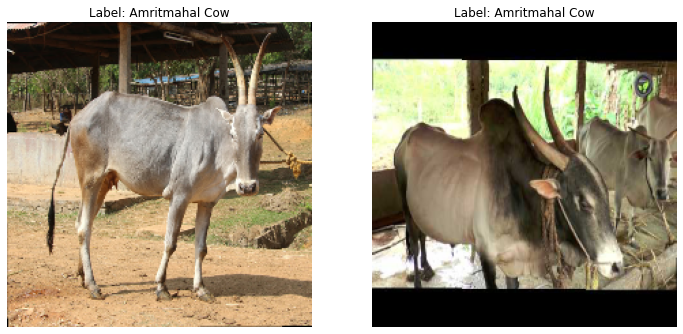

In [ ]:
#lets visualize some sample from cattle_image_rotated
#disply 2 images from each category
num_of_iteration = 2
for encoded_label,actual_label in encoded_labels_to_actual_labels.items():
  print(f"actual_label : {actual_label}")
  print(f"encoded_label : {encoded_label}")
  selected_tensor = [t for t,i in cattle_image_rotated if i==int(encoded_label)]
  print("selected_tensor length : ",len(selected_tensor))
  display_images_from_tensor(selected_tensor[:2],[actual_label]*len(selected_tensor))
  num_of_iteration = num_of_iteration-1
  if num_of_iteration==0:
    break

##### Image Cropping
In this technique we randomly crop image from a specified location.

We can use the cropping process to remove unwanted parts of an image or to focus on a particular object or region of interest(ROI) with an image.

Like other transformations techniques this process can also be used in data augmentation.

When we crop an image, we are essentially removing some of the pixels in the image. The remaining pixels are then scaled to the original size of the image, resulting in a smaller version of the original image. In some cases, we may also resize the cropped image to a different size.

In pytorch, we can use `torchvision.transforms` module.

- `RandomCrop(size)`
- `CenterCrop(size)`

In [ ]:
#cropping the image from center with size 32 by 32
cropping_transform = transforms.CenterCrop(32)
transformations_chain = transforms.Compose([
    resize_transform,
    cropping_transform,
    pixel_tensor,
])
cattle_dataset_cropped = ImageFolder(root=data_path,transform=transformations_chain)

actual_label : Alambadi Cow
encoded_label : 0
selected_tensor length :  93
num_images : 2


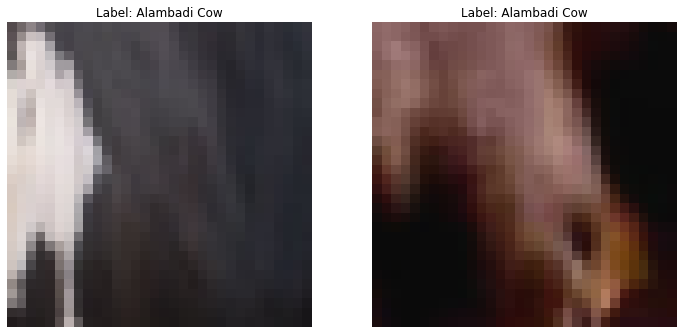

actual_label : Amritmahal Cow
encoded_label : 1
selected_tensor length :  95
num_images : 2


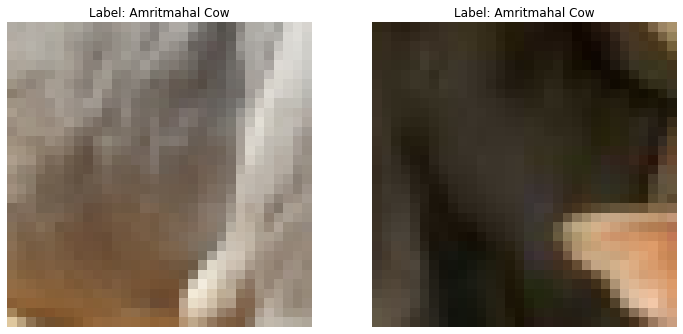

In [ ]:
#visualise the resutant transformed image
#disply 2 images from each category
num_of_iteration = 2
for encoded_label,actual_label in encoded_labels_to_actual_labels.items():
  print(f"actual_label : {actual_label}")
  print(f"encoded_label : {encoded_label}")
  selected_tensor = [t for t,i in cattle_dataset_cropped if i==int(encoded_label)]
  print("selected_tensor length : ",len(selected_tensor))
  display_images_from_tensor(selected_tensor[:2],[actual_label]*len(selected_tensor))
  num_of_iteration = num_of_iteration-1
  if num_of_iteration==0:
    break

#### Image Normalization
- Image normalization is the process of adjusting the pixel values of an image so that they fall within a specific range of values.

- The main goal of normalization is to ensure that all the input data has similar ranges and mean values, which helps in faster convergence of the model during training.

- In PyTorch, we can normalize an image using the `transforms.Normalize()` function. This function takes in two parameters: the mean and standard deviation of the image dataset. The mean and standard deviation values can be calculated using a statistical analysis of the entire dataset, or can be set to pre-determined values.

Calculations of `mean` and `std`:

- There are three ways to evaluate that and it depends on image data and the use case.

- Predetermined values - We can fix the mean and std to some specific value and transform whole data over it.

- Statistical evaluation across all data - We can take all the tensors and calulate the mean and std over that.

- Statistical evaluation across all data on lebel level - We can calculate std and mean for each level seperately and then apply transformation over he data.





In [ ]:
#transformed the image using pre detrmined values
normalize_transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transformations_chain = transforms.Compose([
    resize_transform,
    pixel_tensor,
    normalize_transform
])
cattle_dataset_normalized = ImageFolder(root=data_path,transform=transformations_chain)

actual_label : Alambadi Cow
encoded_label : 0


selected_tensor length :  93
num_images : 2


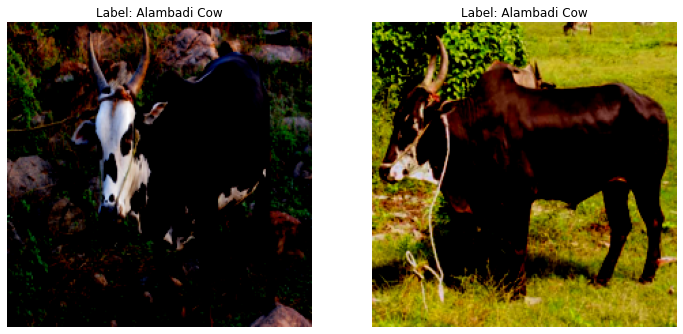

actual_label : Amritmahal Cow
encoded_label : 1


selected_tensor length :  95
num_images : 2


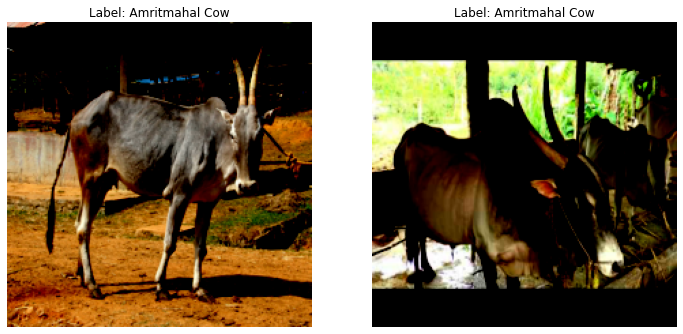

In [ ]:
#visualise the resutant transformed image
#disply 2 images from each category
num_of_iteration = 2
for encoded_label,actual_label in encoded_labels_to_actual_labels.items():
  print(f"actual_label : {actual_label}")
  print(f"encoded_label : {encoded_label}")
  selected_tensor = [t for t,i in cattle_dataset_normalized if i==int(encoded_label)]
  print("selected_tensor length : ",len(selected_tensor))
  display_images_from_tensor(selected_tensor[:2],[actual_label]*len(selected_tensor))
  num_of_iteration = num_of_iteration-1
  if num_of_iteration==0:
    break

##### Gray Scaling
- Grayscale conversion can be useful in reducing the computational cost of model training as it reduces the number of channels from 3 (RGB) to 1.
- Additionally, in certain scenarios where color information is not relevant, converting the images to grayscale can help the model focus on more relevant features.

In [ ]:
#transform the image to blck and white
#transformed the image using pre detrmined values
gray_transform = transforms.Grayscale()
transformations_chain = transforms.Compose([
    gray_transform,
    resize_transform,
    pixel_tensor
])
cattle_dataset_gray_scale = ImageFolder(root=data_path,transform=transformations_chain)

actual_label : Alambadi Cow
encoded_label : 0
selected_tensor length :  93
num_images : 2


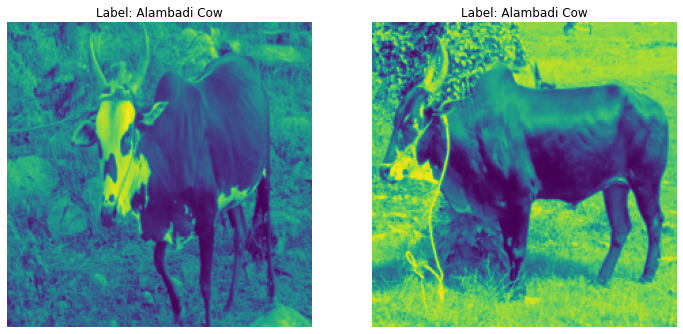

actual_label : Amritmahal Cow
encoded_label : 1
selected_tensor length :  95
num_images : 2


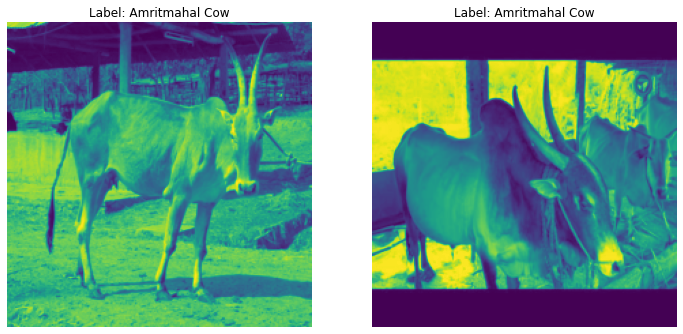

In [ ]:
#visualise the resutant transformed image
#disply 2 images from each category
num_of_iteration = 2
for encoded_label,actual_label in encoded_labels_to_actual_labels.items():
  print(f"actual_label : {actual_label}")
  print(f"encoded_label : {encoded_label}")
  selected_tensor = [t for t,i in cattle_dataset_gray_scale if i==int(encoded_label)]
  print("selected_tensor length : ",len(selected_tensor))
  display_images_from_tensor(selected_tensor[:2],[actual_label]*len(selected_tensor))
  num_of_iteration = num_of_iteration-1
  if num_of_iteration==0:
    break

So that's all we have for image transformations. I have covered most of the image transformation techniques.
Let's modularize the above code that we used for transforming the images.

If you look at the code, we are basically transforming the images and then one by one we are visualizing it to see the transformed image.

We can define two functions for these task. first for transforming the image and 2nd for visualizing the resultant transformations.

In [ ]:
#define a function for chaining transformation
import torchvision.transforms as transforms

'''
    Returns a composed transform of the given list of transforms.

'''

def get_transform(transform_list):

    transform = transforms.Compose(transform_list)
    return transform

In [ ]:
#function for visualizing the resultant transformations
'''

function to display sample transformed images
input - image dataset
ouput - a pair of images per num_of_labels

'''
import random

def display_sample_images(datasets,num_of_labels):

  label_list = list(encoded_labels_to_actual_labels.keys())
  random_label_list = random.sample(label_list,num_of_labels)
  for label in random_label_list:
    print(f"actual_label : {encoded_labels_to_actual_labels[label]}")
    print(f"encoded_label : {label}")
    selected_tensor = [t for t,i in datasets if i==int(label)]
    print("selected_tensor length : ",len(selected_tensor))
    display_images_from_tensor(selected_tensor[:2],[actual_label]*len(selected_tensor))

In [ ]:
random.sample([1,2,3],3)[:2]

In [ ]:
#test out above functions
transformation_chain = get_transform([transforms.Resize((224,224)),transforms.RandomRotation(0.5),transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])
tranformed_image = ImageFolder(root=data_path,transform=transformation_chain)
display_sample_images(tranformed_image,3)

actual_label : Nagpuri Buffalo
encoded_label : 17
selected_tensor length :  217


NameError: ignored

In [ ]:
sizes = [img[0].size for img in dataset] # list of image sizes

# Plot a histogram of the image sizes
plt.hist(sizes, bins=50)
plt.title('Image Size Distribution')
plt.xlabel('Image Size (pixels)')
plt.ylabel('Count')
plt.show()

In [ ]:
intensities = []
for img,i in [dataset[0]]:
    intensities.extend(img.view(-1).tolist()) # flatten the image tensor and add to the intensities list

# Plot a histogram of the pixel intensities
plt.hist(intensities, bins=256, range=[0, 1])
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Count')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Get pixel intensity values for all images in dataset
images = []
for img,_ in dataset:
    images.extend(img.view(-1).tolist())
# Perform PCA on image data


In [ ]:
pca = PCA(n_components=2)
pca.fit(images)
reduced_data = pca.transform(images)

## Model Building

### Train/Validation/Test split

In order to train our model we need to split the dataset into `2` segment mainly in test and train.

The popular or most frequent ratio is `80:20` i.e train is `80%` and `20%` is test dataset.

But this is the case when you have equal number or similar number of instances for each label. But if the overall distrubution is skewed we can not split the data in `80:20` wrt total count.

We need to do this split wrt each label count in the data.

So If label `x` has `10` instances and label `y` has `20` then final train dataset will have `8` instances of x and 16 instances of `y` and test dataset will have `2` and `4` instances of `x` and `y` respectively.

In pytorch, we can use `Subset` functionality of `torch.utils.data` module.


In [ ]:
import random
from collections import defaultdict
from torch.utils.data import Subset, random_split

'''


    `train_test_split` will split the dataset based on split  fraction and number of instances each class has
    input : dataset, split_fraction
    output : train and test dataset


'''

def train_test_validation_split(dataset,validation_split_fraction,test_split_fraction):

  dataloader = {}

  print("test split fraction : ",test_split_fraction)
  print("validation split fraction : ",validation_split_fraction)

  train_split_fraction = 1 - validation_split_fraction - test_split_fraction

  #create a dict which will contains lables and corresponding indices in dataset
  label_to_indices = defaultdict(list)

  for idx, (img,label) in enumerate(dataset):

    label_to_indices[label].append(idx)
  print(label_to_indices.keys())

  label_counts = [(label,len(indices)) for label,indices in label_to_indices.items()]
  #sort the labels with based on the instance count they have in dataset
  label_counts.sort(key = lambda x : x[1])
  print(label_counts)
  train_indices = []
  test_indices = []
  validation_indices = []

  for label,count in label_counts:

    print(label,count)
    num_train = int(count*train_split_fraction)
    print("num train : ",num_train)
    num_validation = int(count*validation_split_fraction)
    train_indices.extend(random.sample(label_to_indices[label],num_train))
    validation_indices.extend(random.sample([idx for idx in label_to_indices[label] if idx not in train_indices],num_validation))
    test_indices.extend([idx for idx in [idx for idx in label_to_indices[label] if idx not in train_indices] if idx not in validation_indices])

  train = Subset(dataset,train_indices)
  print("train size : ",len(train))
  test = Subset(dataset,test_indices)
  print("test size : ",len(test))
  validation = Subset(dataset,validation_indices)

  #append in dataloader
  dataloder
  return train,validation,test

In [ ]:
#split the dataset into test and train by 85 to 15
#(train,test) = train_test_split(dataset,0.85)
#load the data and transformed
from torchvision.datasets import ImageFolder
transformations_chain = get_transform([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])
cattle_dataset_transformed = ImageFolder(root=data_path,transform=transformations_chain)
train_dataset,validation_dataset,test_dataset = train_test_validation_split(cattle_dataset_transformed,0.10,0.10)

test split fraction :  0.1
validation split fraction :  0.1


Now we have split our dataset into train and test split into 85 by 15 ratio.

We will be using train dataset to train our deep learning models and will be using test dataset to evaluate the model performance.

During training we update the parameters of our model by using gradient descent algorithm. So after each iteration we evaluate cost function value and depeding on that we update the model's parameters.

But if we are updating the parameters on each instance of out data that might cause unstability and we might not end up finding global minima.

So, when we train a ml models we update the parameters after evaluating cost functions over batches then average the loss over each instances across a batch.

In `pytorch` we can use `DataLoader` from `torch.utils.data` module.

It loads the data in batches, we can specify the batch size as per our need.

In [ ]:
from torch.utils.data import DataLoader
##apply some transforations over train and test dataset
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=32,shuffle=True)

#### Vannila CNN architecture

This vannial cnn architecture has 4 layers. Each layer except the last one consists of a `2D convolution` layer followed by a `Relu` transformation and finally a `max pooling` layer. The last layer consists of 2 `fully connected` neural networks and an activation function `Relu` in between.
The function of last layer is to map the output of cnn layers i.e first 3 layers to their corresponding labels.

In [ ]:
import torch.nn as nn

'''

This is a simple CNN with three convolutional layers and a fully connected classifier.
The input to the model is a 3-channel image tensor and the output is a tensor of size num_classes.

'''

import torch

class VanillaCNN(nn.Module):

    def __init__(self, num_classes):
        super(VanillaCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.maxpool = nn.AdaptiveMaxPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
            #nn.Softmax()
        )


    def forward(self, x):
        x = self.features(x)
        #print("final dim after conv layer : ",x.shape)
        x = self.maxpool(x)
        #print("final dim after avg pooling : ",x.shape)
        x = torch.flatten(x,1)
        #print("final dim after flattening : ",x.shape)
        x = self.classifier(x)
        #affply softmax
        return x



In [ ]:
#test the above class over one example
type(train_dataset)


torch.utils.data.dataset.Subset

In [ ]:
for i, data in enumerate(train_dataloader, 0):
  inputs, labels = data
  print(inputs[0])
  print(labels[0])
  break

tensor([[[ 0.9216,  0.8588,  0.3333,  ...,  0.5686,  0.5686,  0.5686],
         [ 0.9216,  0.8588,  0.3412,  ...,  0.5686,  0.5686,  0.5686],
         [ 0.9216,  0.8588,  0.3412,  ...,  0.5686,  0.5686,  0.5686],
         ...,
         [ 0.0902,  0.0667,  0.0510,  ...,  0.5059,  0.3647,  0.2314],
         [ 0.1451,  0.1137,  0.1059,  ...,  0.4667,  0.3569,  0.2471],
         [ 0.1373,  0.1059,  0.0824,  ...,  0.3569,  0.3412,  0.3647]],

        [[ 0.9451,  0.8667,  0.3333,  ...,  0.7020,  0.7020,  0.7020],
         [ 0.9451,  0.8667,  0.3333,  ...,  0.7020,  0.7020,  0.7020],
         [ 0.9451,  0.8745,  0.3412,  ...,  0.7020,  0.7020,  0.7020],
         ...,
         [-0.0824, -0.1059, -0.1216,  ...,  0.2706,  0.1294, -0.0039],
         [-0.0275, -0.0588, -0.0667,  ...,  0.2235,  0.1216,  0.0039],
         [-0.0353, -0.0667, -0.0902,  ...,  0.1216,  0.1059,  0.1216]],

        [[ 0.8902,  0.8118,  0.2784,  ...,  0.7647,  0.7647,  0.7647],
         [ 0.8902,  0.8118,  0.2863,  ...,  0

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device : ",device)

# Define the training parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_of_labels = len(cattle_dataset.classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VanillaCNN(num_of_labels).parameters(), lr=learning_rate, momentum=0.8)

# Load the data
#train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
net = VanillaCNN(num_of_labels).to(device)
#set the mode to train
net.train()
# train your model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # calculate the training loss after each epoch
    train_loss = running_loss / len(train_dataloader)

    # calculate the validation loss after each epoch
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(validation_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(validation_dataloader)

    # log the training and validation losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

device :  cpu


KeyboardInterrupt: ignored

In [ ]:
|#test the model
#change the model state to eval
net.eval()
#the auto_grad flag as false
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_dataloader:
      # Move tensors to the configured device
      images = images.to(device)
      labels = labels.to(device)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy of the network on the 10000 test images: 5.151515151515151 %


#### Loss vs Number of Epoch

In [ ]:
#plot number of epoch vs train/validation loss


#### Hyperparameter tuning

#### Data Augmentation

In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=119577a1abc307e1fa0a3fc0eb7f798a739286b7020afa3ed636b9761fcc7ae2
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [ ]:
from pyngrok import ngrok

# Open an SSH tunnel to the notebook server
ngrok_tunnel = ngrok.connect(port='8888')

#### Transfer Learning


- It is a technique used in deep learning where a pre-trained model is used as a starting point for solving a new, related problem. In other words, instead of starting from scratch and training a new model on a large dataset, transfer learning allows us to leverage the knowledge gained from training a model on a different but related dataset.

- Transfer learning has been successfully applied in a wide range of applications, including image classification, object detection, natural language processing, and speech recognition.

Some of the Famous complex CNN architectures trained for Image Classification tasks are:

              | Architecture        | Year | # Parameters | Top-1 Accuracy | Top-5 Accuracy|
              |---------------------|------|-------------|----------------|----------------|
              | AlexNet             | 2012 | 61M         | 56.8%          | 79.3%          |
              | VGG16               | 2014 | 138M        | 71.5%          | 90.0%          |      
              | ResNet-18           | 2015 | 11.7M       | 69.8%          | 89.8%          |
              | ResNet-50           | 2015 | 25.6M       | 76.1%          | 92.9%          |
              | Inception-v4        | 2016 | 41M         | 80.2%          | 95.2%          |
              | DenseNet-121        | 2016 | 8.1M        | 74.9%          | 92.2%          |
              | ResNet-101          | 2016 | 44.6M       | 77.4%          | 93.8%          |



These are some winner architectures of annual `ImageNet` challenge on different years.

I will be using these pretrained architectures for our task and will try to evaluate the model performance on each architecture.

In `pytorch` we can use `torchvision.models` module. This module contains a number of popular pretrained models, including `VGG`, `ResNet`, and `Inception`.






In [ ]:
#function for getting pretrained models with last layer having same node as number of lables in our case

import torch.nn as nn
import torchvision.models as models

def get_pretrained_model(pretrained_model_name,num_labels):

  #get the pretrained model using users input
  pretrained_model = getattr(models,pretrained_model_name)(pretrained=True)
  #extract last layer input features
  if pretrained_model_name.find("res")!=-1 or pretrained_model_name.find("incep")!=-1:
    last_layer_in_features = pretrained_model.fc.in_features
    # Replace last layer with new layer
    new_layer = nn.Linear(last_layer_in_features, num_labels)
    pretrained_model.fc = new_layer
    return pretrained_model
  else:
    last_layer_in_features = pretrained_model.classifier[-1].in_features
    # Replace last layer with new layer
    pretrained_model.classifier[-1] = nn.Linear(last_layer_in_features, num_labels)
    return pretrained_model

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


def get_pretrained_model(pretrained_model_name, num_labels):

    if(pretrained_model_name.find("efficientnet")!=-1):
      model = EfficientNet.from_name('efficientnet-b0')
      return model

    # Get the pretrained model using user's input
    pretrained_model = getattr(models, pretrained_model_name)(pretrained=True)

    #get list of layers
    child_list = list(pretrained_model.children())
    last_layer = child_list[-1]

    #check if the last layer has classifier module or just a fully connected layer
    if isinstance(last_layer,nn.Sequential):

      last_layer_in_features = last_layer[-1].in_features
      pretrained_model.classifier[-1] = nn.Linear(last_layer_in_features, num_labels)
      return pretrained_model

    else:

      last_layer_in_features = last_layer.in_features
      pretrained_model.fc = nn.Linear(last_layer_in_features, num_labels)
      return pretrained_model

In [ ]:
print(list(filter(lambda x:x.find("Eff")==-1,dir(models))))

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_Weights', 'RegNet_X_3_2GF_Weights', 'RegNet_X_400MF_Weights', 'RegNet_X_800MF_Weights', 'RegNet_X_8GF_Weights', 'RegNet_Y_128GF_Weights', 'RegNet_Y_16GF_Weights', 'RegNet_Y_1_6GF_Weights', 'RegNet_Y_32GF_Weights', 'RegNet_Y_3_2GF_Weights', 'RegNet_Y_400MF_Weights', 'RegNet_Y_800MF_Weights', 'RegNet_Y_8GF_Weights', 'Re

In [ ]:
import torch

In [ ]:
# Set the random seed
torch.manual_seed(42)

pretrained_models = ["vgg16","alexnet","inception_v3","resnet101","efficientnet-b2"]
# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device : ",device)

for pretrained_model in pretrained_models:

  model = get_pretrained_model(pretrained_model,len(cattle_dataset.classes)).to(device)
  #test the model
  for param in model.parameters():
      param.requires_grad = False
  #change the model state to eval
  model.eval()
  #the auto_grad flag as false
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_dataloader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the {} network on the 10000 test images: {} %'.format(pretrained_model,100 * correct / total))

device :  cpu


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Accuracy of the vgg16 network on the 10000 test images: 4.286892003297609 %


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Accuracy of the alexnet network on the 10000 test images: 4.2456718878812865 %


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Accuracy of the inception_v3 network on the 10000 test images: 4.616652926628195 %


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Accuracy of the resnet101 network on the 10000 test images: 5.317394888705689 %
Accuracy of the efficientnet-b2 network on the 10000 test images: 0.0 %


In [ ]:
model = getattr(models, "resnet18")(pretrained=True)

In [ ]:
for name, param in model.named_parameters():
  print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [ ]:
list(model.children())[-1]

Linear(in_features=512, out_features=1000, bias=True)

#### Fine Tuning

Fine-tuning is the process of taking a pretrained neural network model and training it on a new dataset to improve its performance on the new task. The general idea is to use the pretrained model as a starting point and then modify the model's architecture and/or weights to better fit the new data.

Here are the general steps for fine-tuning a pretrained model:

1. **Load the pretrained model:** Load the pretrained model's weights and architecture.
2. **Replace the last layer:** Replace the last layer of the model with a new layer that matches the number of classes in your new dataset.
3. **Freeze layers:** Freeze the weights of the initial layers of the model so that only the weights of the new layers will be updated during training.
4. **Train the model:** Train the model on the new dataset, either from scratch or by fine-tuning the existing weights.
5. **Evaluate the model:** Evaluate the model's performance on a separate validation or test dataset to assess its accuracy.
6. **Adjust hyperparameters:** Adjust the model's hyperparameters, such as the learning rate, batch size, and number of epochs, to improve the model's performance.
7. **Repeat steps 4-6:** Repeat the process of training and evaluation, adjusting the hyperparameters as necessary, until the model achieves satisfactory performance.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def get_model_for_fine_tuning(model,train_length):
    """
    Fine-tune a pre-trained model on a new task for a given number of epochs.

    Args:
        model (nn.Module): Pre-trained model to be fine-tuned
        dataloader (DataLoader): Data loader for the new task
        optimizer (optim.Optimizer): Optimization algorithm
        criterion (nn.Module): Loss function
        epochs (int): Number of epochs to train for
        train_length (int): Number of layers to train from the end of the model

    Returns:
      A pretrained model for fine tuning
    """

    # Freeze all layers except the last `train_length` layers
    for param in model.parameters():
        param.requires_grad = False

    #unfreeze the layers upto train_length from end
    for i, module in enumerate(model.modules()):
        if i >= len(list(model.modules())) - train_length:
            for param in module.parameters():
                param.requires_grad = True

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    return model


In [ ]:

def model_training(train_dataloader, validation_dataloader, model_name, model,optimizer, criterion, epochs):

    """
        train a model on a new task for a given number of epochs.

        Args:
            train_dataloader : Training dataset on which we want to train the model
            validation_dataloader : Validation dataset to see if model is not overfitting
            model (nn.Module): Pre-trained model to be fine-tuned
            optimizer (optim.Optimizer): Optimization algorithm
            criterion (nn.Module): Loss function
            epochs (int): Number of epochs to train for

        Returns:
            The trained model
    """

    print("number of epochs : "+epochs)

    #save train loss, validation loss and number of epochs
    train_losses = []
    val_losses = []
    num_of_epochs = []

    # Train the model
    for epoch in range(epochs):
        running_train_loss = 0.0

        #set model state to train
        model.train()

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        train_losses.append(epoch_loss)

        # calculate the validation loss after each epoch
        running_val_loss = 0.0

        with torch.no_grad():

          #set model to eval state
          model.eval()

          for inputs, labels in validation_dataloader:

              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(validation_dataloader.dataset)
        val_losses.appned(epoch_val_loss)
        num_of_epochs.append(epoch)

        # log the training and validation losses
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    model_dict = {
        "model_name": model_name,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "epochs": num_of_epochs
    }

    return model, model_dict



In [ ]:
for i,j in train_dataloader:
  print(i.shape)
  print(j.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
model = get_pretrained_model("resnet101",len(cattle_dataset.classes))
fine_tune_model(model,train_dataloader,optim.SGD(model.parameters(), lr=0.001, momentum=0.8),nn.CrossEntropyLoss(),30,1)

NameError: ignored

In [ ]:
#test the model
#change the model state to eval
model.eval()
#the auto_grad flag as false
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in train_dataloader:
      # Move tensors to the configured device
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 66.98268755152515 %


#### Model Evaluations